In [1]:
import torch
from ray import tune
import ray
import numpy as np
import os
from pytorch_optimizer import AvaGrad 
from train import train
import pickle
from ray.train.lightning import LightningTrainer
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter



## Loading and Cleaning Metrics

In [10]:
result_grid = tune.Tuner.restore("tune_cifar10_SmallNet_divya", trainable=LightningTrainer).get_results()
metrics_df = result_grid.get_dataframe()
#metrics_df = pd.concat([pd.concat([result, result.metrics_dataframe], axis=1) for result in analysis], ignore_index=True)
display(metrics_df)

,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,config/lightning_config/_trainer_init_config/callbacks,config/lightning_config/_trainer_init_config/limit_train_batches,config/lightning_config/_trainer_init_config/limit_val_batches,config/lightning_config/_trainer_init_config/logger,config/lightning_config/_trainer_init_config/max_epochs,config/lightning_config/_module_init_config/config/SAM,config/lightning_config/_module_init_config/config/optimizer,config/lightning_config/_module_init_config/config/parameters/lr,config/lightning_config/_module_init_config/config/parameters/weight_decay,logdir
0,train_epoch_end,2.302792,2.302599,9,3910,1688025521,3.564371,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,True,<class 'torch.optim.sgd.SGD'>,0.100000,10.000000,tune_cifar10_SmallNet_divya/LightningTrainer_a...
1,train_epoch_end,2.302785,2.302598,9,3910,1688025563,3.270869,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,False,<class 'torch.optim.sgd.SGD'>,0.100000,10.000000,tune_cifar10_SmallNet_divya/LightningTrainer_a...
2,train_epoch_end,2.302558,2.302586,9,3910,1688025610,3.675420,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.100000,10.000000,tune_cifar10_SmallNet_divya/LightningTrainer_a...
3,train_epoch_end,2.302560,2.302587,9,3910,1688025654,3.439179,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.100000,10.000000,tune_cifar10_SmallNet_divya/LightningTrainer_a...
4,train_epoch_end,2.302563,2.302593,9,3910,1688025699,3.591244,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,True,<class 'torch.optim.sgd.SGD'>,0.027826,10.000000,tune_cifar10_SmallNet_divya/LightningTrainer_a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,train_epoch_end,2.297622,2.303805,9,3910,1688043369,3.490704,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.000004,0.000001,tune_cifar10_SmallNet_divya/LightningTrainer_a...
396,train_epoch_end,2.310323,2.306486,9,3910,1688043416,3.665980,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,True,<class 'torch.optim.sgd.SGD'>,0.000001,0.000001,tune_cifar10_SmallNet_divya/LightningTrainer_a...
397,train_epoch_end,2.324137,2.307007,9,3910,1688043459,3.409472,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,False,<class 'torch.optim.sgd.SGD'>,0.000001,0.000001,tune_cifar10_SmallNet_divya/LightningTrainer_a...
398,train_epoch_end,2.306817,2.308258,9,3910,1688043507,3.845357,True,False,10,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,10,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.000001,0.000001,tune_cifar10_SmallNet_divya/LightningTrainer_a...


In [3]:
metrics_df_cleaned= metrics_df.rename(columns={"config/lightning_config/_module_init_config/config/SAM":"SAM", "config/lightning_config/_module_init_config/config/optimizer":"optimizer", "config/lightning_config/_module_init_config/config/parameters/lr":"lr","config/lightning_config/_module_init_config/config/parameters/weight_decay":"weight_decay" })
metrics_df_cleaned = metrics_df_cleaned[["val_loss", "train_loss", "epoch", "lr", "weight_decay", "optimizer", "SAM"]]
display(metrics_df_cleaned.head())

,val_loss,train_loss,epoch,lr,weight_decay,optimizer,SAM
0,2.302792,2.302599,9,0.100000,10.0,<class 'torch.optim.sgd.SGD'>,True
1,2.302785,2.302598,9,0.100000,10.0,<class 'torch.optim.sgd.SGD'>,False
2,2.302558,2.302586,9,0.100000,10.0,<class 'pytorch_optimizer.optimizer.avagrad.Av...,True
3,2.302560,2.302587,9,0.100000,10.0,<class 'pytorch_optimizer.optimizer.avagrad.Av...,False
4,2.302563,2.302593,9,0.027826,10.0,<class 'torch.optim.sgd.SGD'>,True


## Convergence

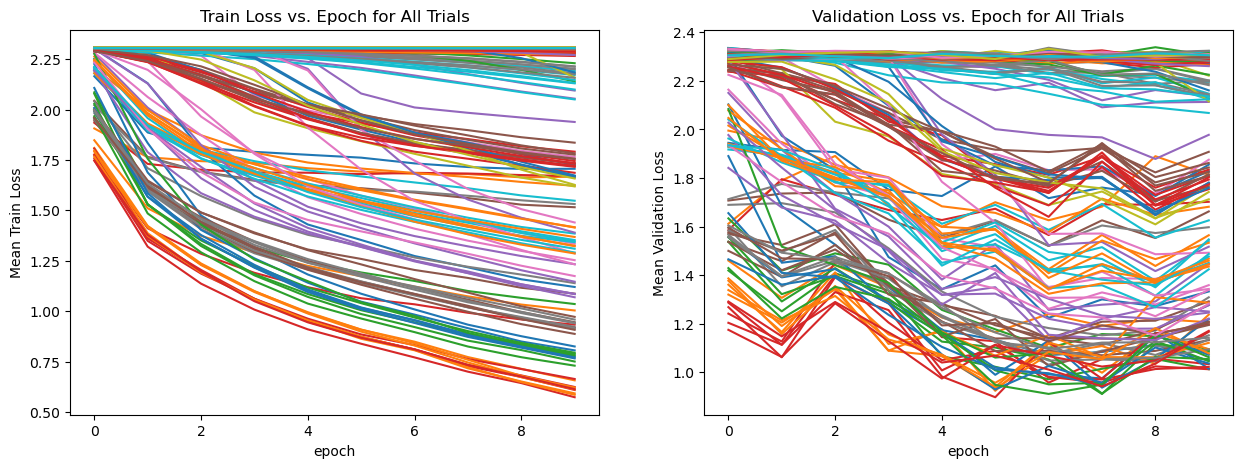

In [18]:
def plot_all(result_grid):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    for result in result_grid:
        parameters = result.config["lightning_config"]["_module_init_config"]["config"]["parameters"]
        label = f"lr={parameters['lr']}, momentum={parameters['weight_decay']}"
        result.metrics_dataframe.plot("epoch", "train_loss", ax=ax[0], legend=False)
        result.metrics_dataframe.plot("epoch", "val_loss", ax=ax[1], legend=False)
    ax[0].set_title("Train Loss vs. Epoch for All Trials")
    ax[1].set_title("Validation Loss vs. Epoch for All Trials")
    ax[0].set_ylabel("Mean Train Loss")
    ax[1].set_ylabel("Mean Validation Loss")
plot_all(result_grid)

## Function for creating Heatmaps

In [4]:
def plot_heatmap_2d(ax, df, title="Default Title"):
    sns.heatmap(df, ax=ax, vmin=1, vmax=2.5)

    # Format x-tick labels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [f'{float(label):.1e}' for label in labels]
    ax.set_xticklabels(labels)

    # Format y-tick labels
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels = [f'{float(label):.1e}' for label in labels]
    ax.set_yticklabels(labels)
    ax.set_title(title)
    plt.tight_layout()

# Results

## Without SAM

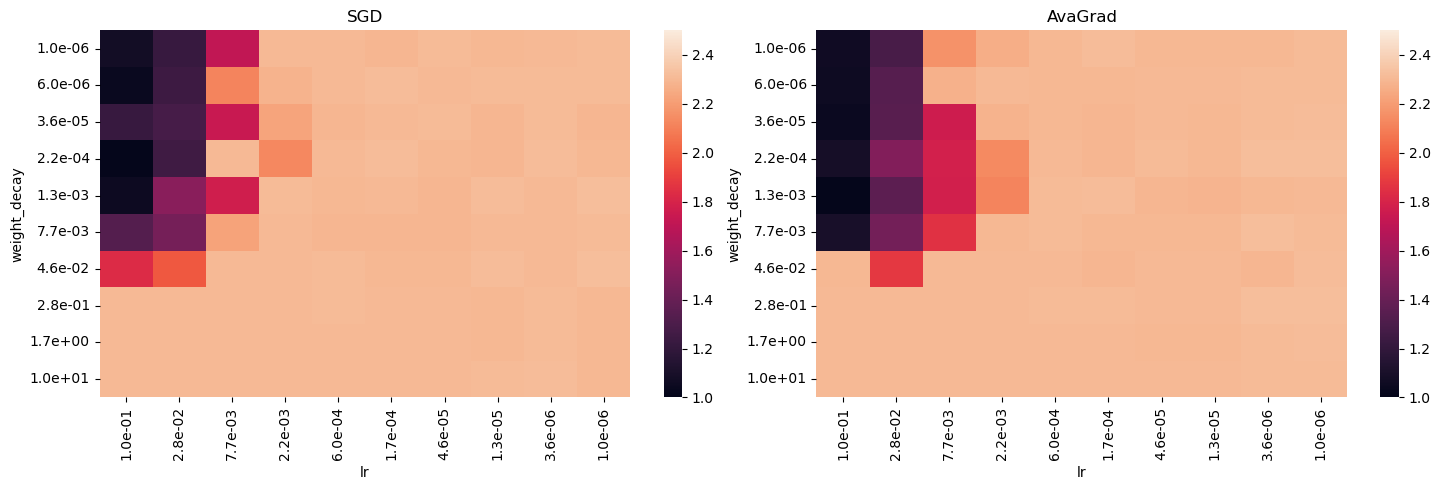

In [5]:
df = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
df.sort_index(axis=1, inplace=True, ascending=False)
df2 = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
df2.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], df, "SGD")
plot_heatmap_2d(axs[1], df2, "AvaGrad")
plt.show()

## With SAM

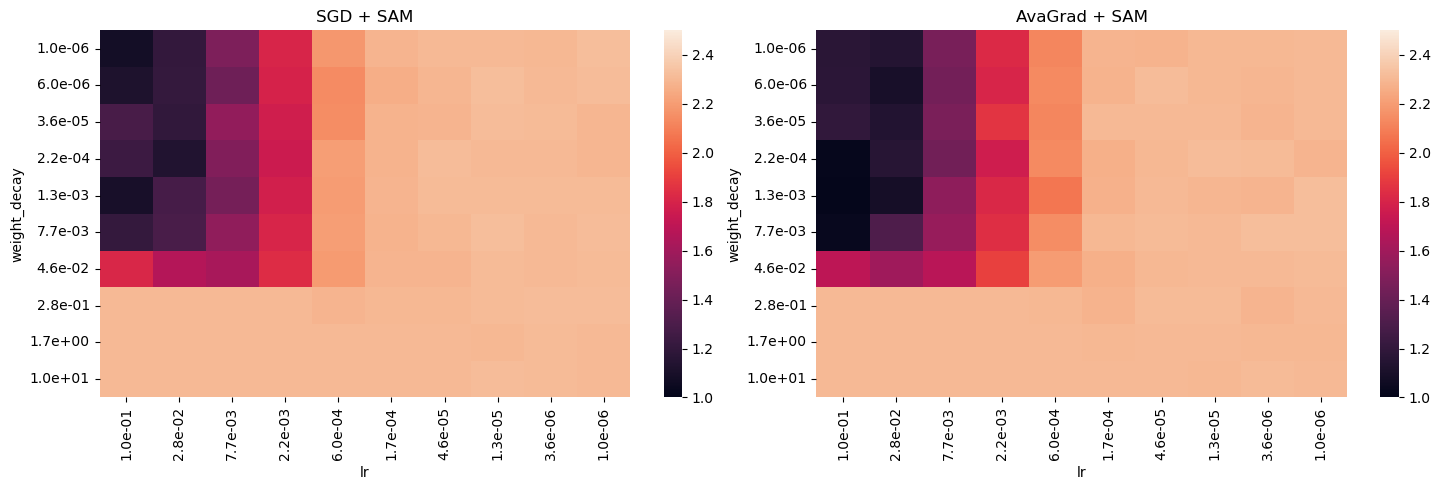

In [7]:
df = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
df.sort_index(axis=1, inplace=True, ascending=False)
df2 = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
df2.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], df, "SGD + SAM")
plot_heatmap_2d(axs[1], df2 ,"AvaGrad + SAM")
plt.show()